#Trabajo 2 y 3, Almacenamiento y recuperación de información
#Integrantes: Jhonatan Montes, David Alejandro Arboleda, Agustin Nieto, Rafael Gil

Parte del código fue extraído del repo: https://github.com/st1800eafit/st1800-2266

In [2]:
import pandas as pd
import numpy as np
import nltk
import re

In [3]:
# settings en nltk: tokenizador y stopwords
# código extraido de: https://github.com/st1800eafit/st1800-2266
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
tk = TweetTokenizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ragil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ragil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# cargar datos en pandas
df = pd.read_csv('C:\Alejandro Gil\Maestria\Alm y Rec Datos\Trabajo23\TwitterClimateData.csv', sep=';')
#df = pd.read_csv('gdrive/MyDrive/datasets/metadata.csv')

In [5]:
# analisis descriptivo de datos
df.head()

,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,hashtags,geo,urls,search_hashtags,location
0,0,1.21181e+18,7.590000e+17,"2020 is the year we #votethemout, the year we ...",15,https://twitter.com/Sphiamia/status/1211807074...,2019-12-31 00:31:35+00:00,Tue Dec 31 00:31:35 +0000 2019,46,NaN,#votethemout #climatestrike #rebelforlife,NaN,NaN,#climatestrike,"California, USA"
1,1,1.21067e+18,2.219547e+07,Winter has not stopped this group of dedicated...,9,https://twitter.com/StephDujarric/status/12106...,2019-12-27 20:56:21+00:00,Fri Dec 27 20:56:21 +0000 2019,35,NaN,#climatefriday #climatestrike #ClimateAction,NaN,NaN,#climatestrike,"California, USA"
2,2,1.21059e+18,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,545,https://twitter.com/AlexandriaV2005/status/121...,2019-12-27 15:50:22+00:00,Fri Dec 27 15:50:22 +0000 2019,3283,@UN @Fridays4future,#ClimateStrike,NaN,NaN,#climatestrike,"California, USA"
3,3,1.21026e+18,1.339821e+09,"A year of resistance, as youth protests shaped...",1,https://twitter.com/EnergyHouseVA/status/12102...,2019-12-26 17:53:26+00:00,Thu Dec 26 17:53:26 +0000 2019,2,NaN,#greta #gretathunberg #climatechange #fridaysf...,NaN,https://www.channelnewsasia.com/news/commentar...,#climatestrike,"California, USA"
4,4,1.20964e+18,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,1,https://twitter.com/EnergyHouseVA/status/12096...,2019-12-25 00:56:37+00:00,Wed Dec 25 00:56:37 +0000 2019,4,NaN,#greta #gretathunberg #climatechange #fridaysf...,NaN,"http://www.energyhouse.us,http://www.pacenowfo...",#climatestrike,"California, USA"


In [6]:
#Visualizamos la forma del DF
df.shape

(72405, 15)

In [7]:
#Contamos los registros en cada columna del DF
df.count()

Unnamed: 0         72405
id                 72405
author_id          72405
text               72405
retweets           72405
permalink          72405
date               72405
formatted_date     72405
favorites          72405
mentions           27554
hashtags           72402
geo                    0
urls               33349
search_hashtags    72405
location           72405
dtype: int64

In [8]:
# Inicio del proceso LDA
# filtrar las columnas de interés
df = df[['author_id','text','permalink','hashtags','search_hashtags']]
df.head()

,author_id,text,permalink,hashtags,search_hashtags
0,7.590000e+17,"2020 is the year we #votethemout, the year we ...",https://twitter.com/Sphiamia/status/1211807074...,#votethemout #climatestrike #rebelforlife,#climatestrike
1,2.219547e+07,Winter has not stopped this group of dedicated...,https://twitter.com/StephDujarric/status/12106...,#climatefriday #climatestrike #ClimateAction,#climatestrike
2,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,https://twitter.com/AlexandriaV2005/status/121...,#ClimateStrike,#climatestrike
3,1.339821e+09,"A year of resistance, as youth protests shaped...",https://twitter.com/EnergyHouseVA/status/12102...,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike
4,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,https://twitter.com/EnergyHouseVA/status/12096...,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike


In [9]:
##### Buscar los hastags unicos para inferir el k optimo ####
df2 = df[['search_hashtags']]
df2 = df2.drop_duplicates()
df2.count()

search_hashtags    12
dtype: int64

In [10]:
# función general para preparación de datos: tokenización, remoción caracteres especiales
# En nuestro caso solo filtramos palabras, dejamos por fuera fechas y frases alfanuméricas
def textprep(line):
    tokens = nltk.word_tokenize(str(line))
    tokens = [w.lower() for w in tokens if len(w)>1]
    #tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if w not in stop_words_nltk] 
    return tokens

def textprepTwit(line):
    tokens = tk.tokenize(line)
    tokens = [w.lower() for w in tokens if len(w)>1]
    tokens = [w for w in tokens if w not in stop_words_nltk] 
    return tokens

In [11]:
# Creamos la columna de tokens a partir de la tokenización de la columna text
df['tokens_text'] = df.apply(lambda row: textprep(row['text']), axis=1)
# Creamos la columna de tokensTwit a partir de la tokenización de la columna text
df['tokens_text_twit'] = df.apply(lambda row: textprepTwit(row['text']), axis=1)
df.head()

,author_id,text,permalink,hashtags,search_hashtags,tokens_text,tokens_text_twit
0,7.590000e+17,"2020 is the year we #votethemout, the year we ...",https://twitter.com/Sphiamia/status/1211807074...,#votethemout #climatestrike #rebelforlife,#climatestrike,"[year, votethemout, year, climatestrike, heart...","[2020, year, #votethemout, year, #climatestrik..."
1,2.219547e+07,Winter has not stopped this group of dedicated...,https://twitter.com/StephDujarric/status/12106...,#climatefriday #climatestrike #ClimateAction,#climatestrike,"[winter, stopped, group, dedicated, climate, a...","[winter, stopped, group, dedicated, climate, a..."
2,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,https://twitter.com/AlexandriaV2005/status/121...,#ClimateStrike,#climatestrike,"[week, climatestrike, un, next, week, heads, y...","[week, 55, #climatestrike, @un, next, week, @f..."
3,1.339821e+09,"A year of resistance, as youth protests shaped...",https://twitter.com/EnergyHouseVA/status/12102...,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike,"[year, resistance, youth, protests, shaped, cl...","[year, resistance, youth, protests, shaped, cl..."
4,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,https://twitter.com/EnergyHouseVA/status/12096...,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike,"[happy, holidays, greta, gretathunberg, climat...","[happy, holidays, #greta, #gretathunberg, #cli..."


In [12]:
import matplotlib.pyplot as plt

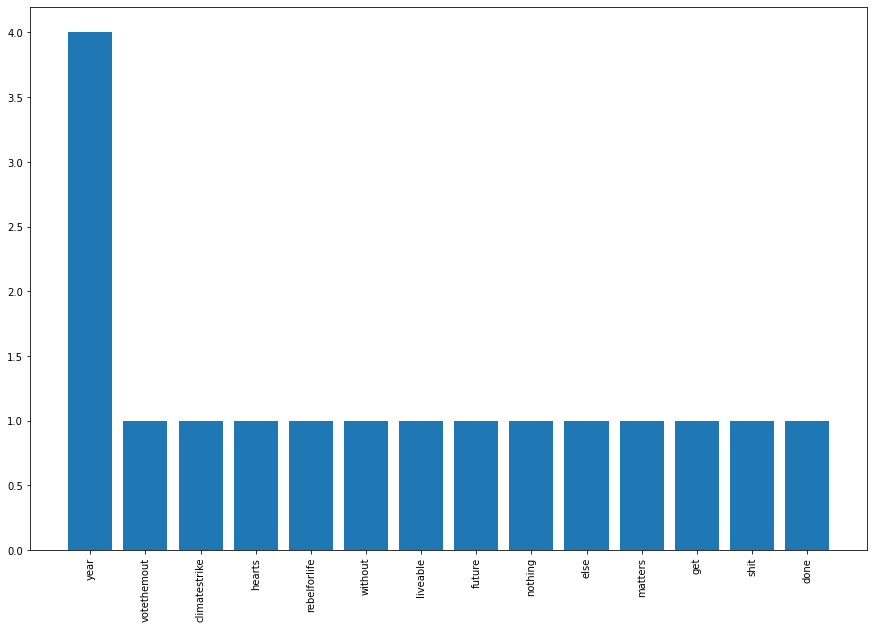

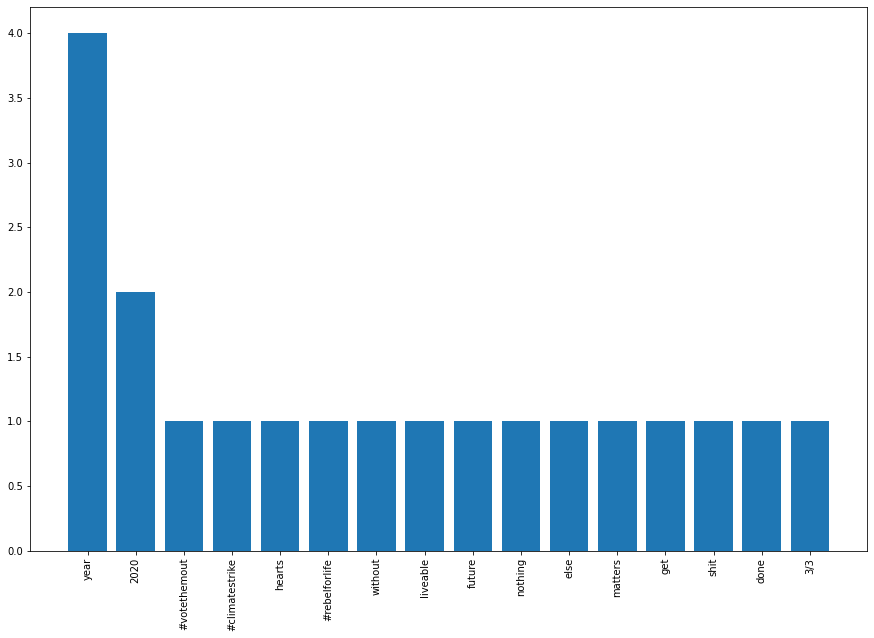

In [13]:
#Vemos la frecuencia de palabras de la fila 0 de la columna de tokens generados con el generador normal vs generador de twitter
fdist = nltk.FreqDist(df.tokens_text[0])
fdistwit = nltk.FreqDist(df.tokens_text_twit[0])
topwords = fdist.most_common(20)
topwordstwit = fdistwit.most_common(20)
# print('numero de palabras finales = ',len(fdist))
# print (topwords)
x,y = zip(*topwords)
x1,y1 = zip(*topwordstwit)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(15,10))
plt.bar(x1,y1)
plt.xticks(rotation=90)
plt.show()

In [14]:
# Creación del BoW
from gensim.corpora import Dictionary
dictionary = Dictionary(df.tokens_text)
dictionarytwit = Dictionary(df.tokens_text_twit)

In [15]:
# libreria para paralelizar, ejecutar hilos en paralelo para que aumente la eficiencia de ejecución
# Representar cada documento en terminos del BoW
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
doc_term_matrix = pool.map(dictionary.doc2bow, [sentence for sentence in df.tokens_text])
doc_term_matrixtwit = pool.map(dictionarytwit.doc2bow, [sentence for sentence in df.tokens_text_twit])
pool.close()

In [16]:
#Entrenamos LDA para clasificar los documentos
#Empleamos el # de hashtags como termino k 
from gensim.models.ldamulticore import LdaMulticore

#lda_model = LdaMulticore(doc_term_matrix, num_topics=df2.count(), id2word = dictionary, passes=10, workers=10)
lda_modeltwit = LdaMulticore(doc_term_matrixtwit, num_topics=df2.count(), id2word = dictionarytwit, passes=10, workers=10)

In [17]:
lda_model = LdaMulticore(doc_term_matrix, num_topics=df2.count(), id2word = dictionary, passes=10, workers=10)

In [18]:
def assigntopic(doc):
    vector = lda_model[dictionary.doc2bow(doc)] 
    # opción 1: todos los tópicos ordenados de mayor a menor, podria ser topN tambien asi: return vector[:5] n=5
    #vector = sorted(vector, key=lambda item: -item[1])
    # opción 2: asignar el tópico mayor a cada documento
    vector = max(vector,key=lambda item: item[1])
    return vector

def assigntopictwit(doc):
    vector = lda_modeltwit[dictionarytwit.doc2bow(doc)] 
    # opción 1: todos los tópicos ordenados de mayor a menor, podria ser topN tambien asi: return vector[:5] n=5
    #vector = sorted(vector, key=lambda item: -item[1])
    # opción 2: asignar el tópico mayor a cada documento
    vector = max(vector,key=lambda item: item[1])
    return vector

df['topics'] = df.apply(lambda row: assigntopic(row['tokens_text']), axis=1)
df['topicstwit'] = df.apply(lambda row: assigntopictwit(row['tokens_text_twit']), axis=1)
df.head()

,author_id,text,permalink,hashtags,search_hashtags,tokens_text,tokens_text_twit,topics,topicstwit
0,7.590000e+17,"2020 is the year we #votethemout, the year we ...",https://twitter.com/Sphiamia/status/1211807074...,#votethemout #climatestrike #rebelforlife,#climatestrike,"[year, votethemout, year, climatestrike, heart...","[2020, year, #votethemout, year, #climatestrik...","(3, 0.5693917)","(1, 0.8984116)"
1,2.219547e+07,Winter has not stopped this group of dedicated...,https://twitter.com/StephDujarric/status/12106...,#climatefriday #climatestrike #ClimateAction,#climatestrike,"[winter, stopped, group, dedicated, climate, a...","[winter, stopped, group, dedicated, climate, a...","(5, 0.92356)","(2, 0.92356503)"
2,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,https://twitter.com/AlexandriaV2005/status/121...,#ClimateStrike,#climatestrike,"[week, climatestrike, un, next, week, heads, y...","[week, 55, #climatestrike, @un, next, week, @f...","(5, 0.9672478)","(0, 0.6519863)"
3,1.339821e+09,"A year of resistance, as youth protests shaped...",https://twitter.com/EnergyHouseVA/status/12102...,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike,"[year, resistance, youth, protests, shaped, cl...","[year, resistance, youth, protests, shaped, cl...","(8, 0.96179163)","(10, 0.6522414)"
4,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,https://twitter.com/EnergyHouseVA/status/12096...,#greta #gretathunberg #climatechange #fridaysf...,#climatestrike,"[happy, holidays, greta, gretathunberg, climat...","[happy, holidays, #greta, #gretathunberg, #cli...","(7, 0.6715871)","(6, 0.9601316)"


In [38]:
# Mostrar los términos y sus pesos de un documento
#print(list(lda_model[doc_term_matrix[0]]))

# Mostrar los términos más relevantes de los tópicos más relevantes tópico y sus pesos
print(lda_model.print_topics())
len(lda_model.print_topics())

[(0, '0.037*"sustainability" + 0.034*"https" + 0.019*"environment" + 0.016*"amp" + 0.016*"savetheplanet" + 0.014*"climatechange" + 0.014*"globalwarming" + 0.010*"earth" + 0.008*"plastic" + 0.007*"nature"'), (1, '0.022*"climatestrike" + 0.013*"climate" + 0.013*"climatechange" + 0.012*"amp" + 0.010*"https" + 0.008*"change" + 0.007*"greennewdeal" + 0.007*"hall" + 0.007*"climateaction" + 0.006*"city"'), (2, '0.021*"de" + 0.017*"climatestrike" + 0.015*"en" + 0.014*"la" + 0.014*"climatechange" + 0.009*"el" + 0.007*"https" + 0.007*"greennewdeal" + 0.007*"que" + 0.007*"environment"'), (3, '0.026*"climatechange" + 0.022*"greennewdeal" + 0.012*"climatestrike" + 0.010*"planet" + 0.009*"climatecrisis" + 0.009*"people" + 0.008*"like" + 0.007*"world" + 0.007*"would" + 0.006*"one"'), (4, '0.037*"climatechange" + 0.010*"globalwarming" + 0.010*"climatecrisis" + 0.008*"https" + 0.006*"environment" + 0.005*"new" + 0.005*"climateaction" + 0.005*"people" + 0.004*"climatestrike" + 0.004*"climate"'), (5, '0.

12

In [20]:
# lda_topic_assignment = [max(p,key=lambda item: item[1]) for p in lda_model[doc_term_matrix]]
# lda_topic_assignmentwit = [max(p,key=lambda item: item[1]) for p in lda_modeltwit[doc_term_matrixtwit]]

In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary, sort_topics = False)
vis


c:\Users\ragil\AppData\Local\Programs\Python\Python37\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Users\ragil\AppData\Local\Programs\Python\Python37\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.198907  0.039832       1        1   7.094891
1      0.023842  0.031594       2        1   5.630622
2     -0.005698 -0.185519       3        1   5.535101
3      0.088958  0.050056       4        1   9.786544
4     -0.002626  0.029961       5        1   8.682764
5      0.145011  0.061486       6        1  14.241615
6     -0.103707  0.065238       7        1   4.681319
7     -0.027027 -0.062109       8        1   5.257024
8      0.179555  0.025813       9        1  10.785598
9      0.017887 -0.197952      10        1   6.137405
10     0.039428  0.096898      11        1  14.373614
11    -0.156716  0.044701      12        1   7.793502, topic_info=                  Term          Freq         Total Category  logprob  loglift
0        climatestrike  20628.000000  20628.000000  Default  30.0000  30.0000
84      sustainability   6991.000000   6991.000000  Default  29.0000  29.0000
2344                de   2290.000000   2290.000000  Default  28.0000  28.0000
52    fridaysforfuture   5618.000000   5618.000000  Default  27.0000  27.0000
3868         bushfires   1755.000000   1755.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
149              great    204.069504   2076.678738  Topic12  -5.9976   0.2318
266                one    208.710679   2495.363739  Topic12  -5.9751   0.0706
75       climatecrisis    229.438431   7660.796843  Topic12  -5.8805  -0.9564
57                love    170.085298   1114.676901  Topic12  -6.1798   0.6719
65              energy    177.337062   1761.732512  Topic12  -6.1380   0.2559

[931 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
19170      2  0.943515       aarp
5535       2  0.017737  achieving
5535      11  0.957817  achieving
119        1  0.000683     action
119        2  0.041690     action
...      ...       ...        ...
85         7  0.003592  zerowaste
85        12  0.003592  zerowaste
22908     12  0.967514        zoo
20259     10  0.982044         ça
15487     10  0.981605       être

[3234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [22]:
vistwit = gensimvis.prepare(lda_modeltwit, doc_term_matrixtwit, dictionarytwit, sort_topics = False)
vistwit

c:\Users\ragil\AppData\Local\Programs\Python\Python37\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.058091  0.073188       1        1  15.318677
1      0.035771  0.040861       2        1   6.139963
2     -0.194881  0.038407       3        1   9.703046
3     -0.192865  0.023532       4        1  15.445746
4      0.136630  0.067244       5        1   4.669443
5      0.129911  0.041183       6        1   5.242157
6      0.064833  0.027932       7        1   4.130367
7     -0.070371 -0.143802       8        1   7.414562
8      0.023104  0.017475       9        1  13.870061
9      0.051740 -0.226709      10        1   5.137964
10    -0.007648  0.040884      11        1   7.867571
11     0.081868 -0.000195      12        1   5.060442, topic_info=                   Term          Freq         Total Category  logprob  loglift
0        #climatestrike  21001.000000  21001.000000  Default  30.0000  30.0000
88      #sustainability   6431.000000   6431.000000  Default  29.0000  29.0000
2677                 de   2361.000000   2361.000000  Default  28.0000  28.0000
55    #fridaysforfuture   5725.000000   5725.000000  Default  27.0000  27.0000
226       #greennewdeal   5816.000000   5816.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
87       #savetheplanet    126.016062   1849.732281  Topic12  -6.1022   0.2973
137                 ...    146.102502   4382.759262  Topic12  -5.9543  -0.4174
8                   get    118.648876   2039.317694  Topic12  -6.1624   0.1395
16       #climateaction    128.265191  10353.664967  Topic12  -6.0845  -1.4073
169               great     97.813858   2032.304420  Topic12  -6.3555  -0.0501

[929 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
18647      3  0.971772   ##organiccotton
18647      7  0.026264   ##organiccotton
33791      2  0.974723    #500k_students
33792      2  0.974716     #50k_teachers
8779      11  0.985992  #a1blockstudents
...      ...       ...               ...
31374     12  0.908126                ही
30447      2  0.025428                है
30447      6  0.012714                है
30447     12  0.947202                है
30516     12  0.963692               हैं

[3000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [28]:
#Encontrar el k optimo
# coherencead = []
# for i in range(1,10):
#     lda_modeltwit = LdaMulticore(doc_term_matrixtwit, num_topics=i, id2word = dictionarytwit, passes=10, workers=10)
#     cm = CoherenceModel(model=lda_modeltwit, corpus=doc_term_matrixtwit, coherence='u_mass')
#     coherence = cm.get_coherence()
#     coherencead.append(coherence)

In [29]:
# coherencead

[-3.0369421296261567,
 -3.279170106731981,
 -3.551379126679604,
 -3.3599950250588666,
 -3.5006385251401695,
 -4.831041640471455,
 -3.826451511516013,
 -4.772955901907958,
 -5.122205419015966]

In [30]:
# coherencead1 = []
# for i in range(10,21):
#     lda_modeltwit = LdaMulticore(doc_term_matrixtwit, num_topics=i, id2word = dictionarytwit, passes=10, workers=10)
#     cm = CoherenceModel(model=lda_modeltwit, corpus=doc_term_matrixtwit, coherence='u_mass')
#     coherence = cm.get_coherence()
#     coherencead1.append(coherence)

In [31]:
# coherencead1

[-4.5148822094828125,
 -4.331340244644346,
 -4.035294761106373,
 -5.3211515063292385,
 -4.7965848231578985,
 -4.358206316312521,
 -5.347645530313407,
 -4.517968752550113,
 -4.313826574318096,
 -4.720784413897339,
 -5.194897826913005]

In [43]:
# filtrar las columnas de interés
df = df[['author_id','text','permalink','hashtags','search_hashtags','tokens_text_twit','topicstwit']]
df.head()
#df.count()
df.to_csv('datosprimeraparte.csv', index=False)